In [1]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")


from IPython.display import display

import numpy as np
import networkx as nx
import qiskit
import sympy
from qiskit import transpile, QuantumCircuit

3834


None

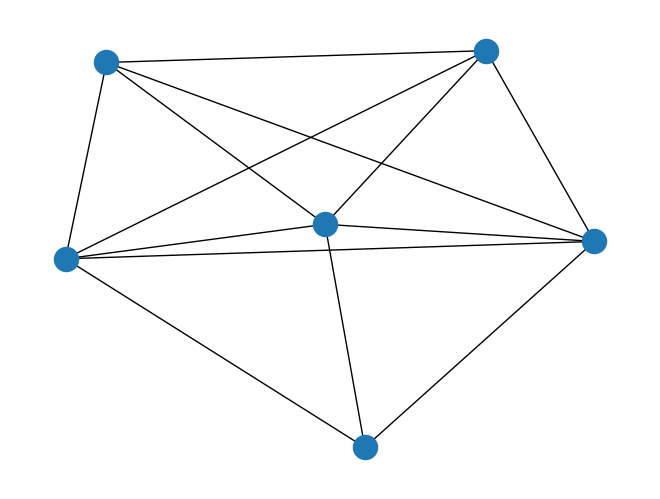

In [2]:
from benchmarklib.databases import CliqueDatabase


db = CliqueDatabase().shared()
clique_problem = db.get(3834)
print(clique_problem.instance_id)

G = nx.from_numpy_array(clique_problem.as_adjacency_matrix())
display(nx.draw(G))

def clique_oracle(vertices: BitVec(6, '000000')) -> BitVec(1):
    """Counts cliques of size 2 in a graph specified by the edge list."""
    s = BitVec(1, 1)
    s = s & ~(vertices[0] & vertices[1])
    s = s & ~(vertices[1] & vertices[5])
    s_0_0 = BitVec(1, 1)
    s_0_1 = BitVec(1, 0)
    s_0_2 = BitVec(1, 0)
    s_0_3 = BitVec(1, 0)
    s_1_0 = BitVec(1, 1)
    s_1_1 = s_0_1 | vertices[0] & s_0_0
    s_1_2 = BitVec(1, 0)
    s_1_3 = BitVec(1, 0)
    s_2_0 = BitVec(1, 1)
    s_2_1 = s_1_1 | vertices[1] & s_1_0
    s_2_2 = s_1_2 | vertices[1] & s_1_1
    s_2_3 = BitVec(1, 0)
    s_3_0 = BitVec(1, 1)
    s_3_1 = s_2_1 | vertices[2] & s_2_0
    s_3_2 = s_2_2 | vertices[2] & s_2_1
    s_3_3 = s_2_3 | vertices[2] & s_2_2
    s_4_0 = BitVec(1, 1)
    s_4_1 = s_3_1 | vertices[3] & s_3_0
    s_4_2 = s_3_2 | vertices[3] & s_3_1
    s_4_3 = s_3_3 | vertices[3] & s_3_2
    s_5_0 = BitVec(1, 1)
    s_5_1 = s_4_1 | vertices[4] & s_4_0
    s_5_2 = s_4_2 | vertices[4] & s_4_1
    s_5_3 = s_4_3 | 

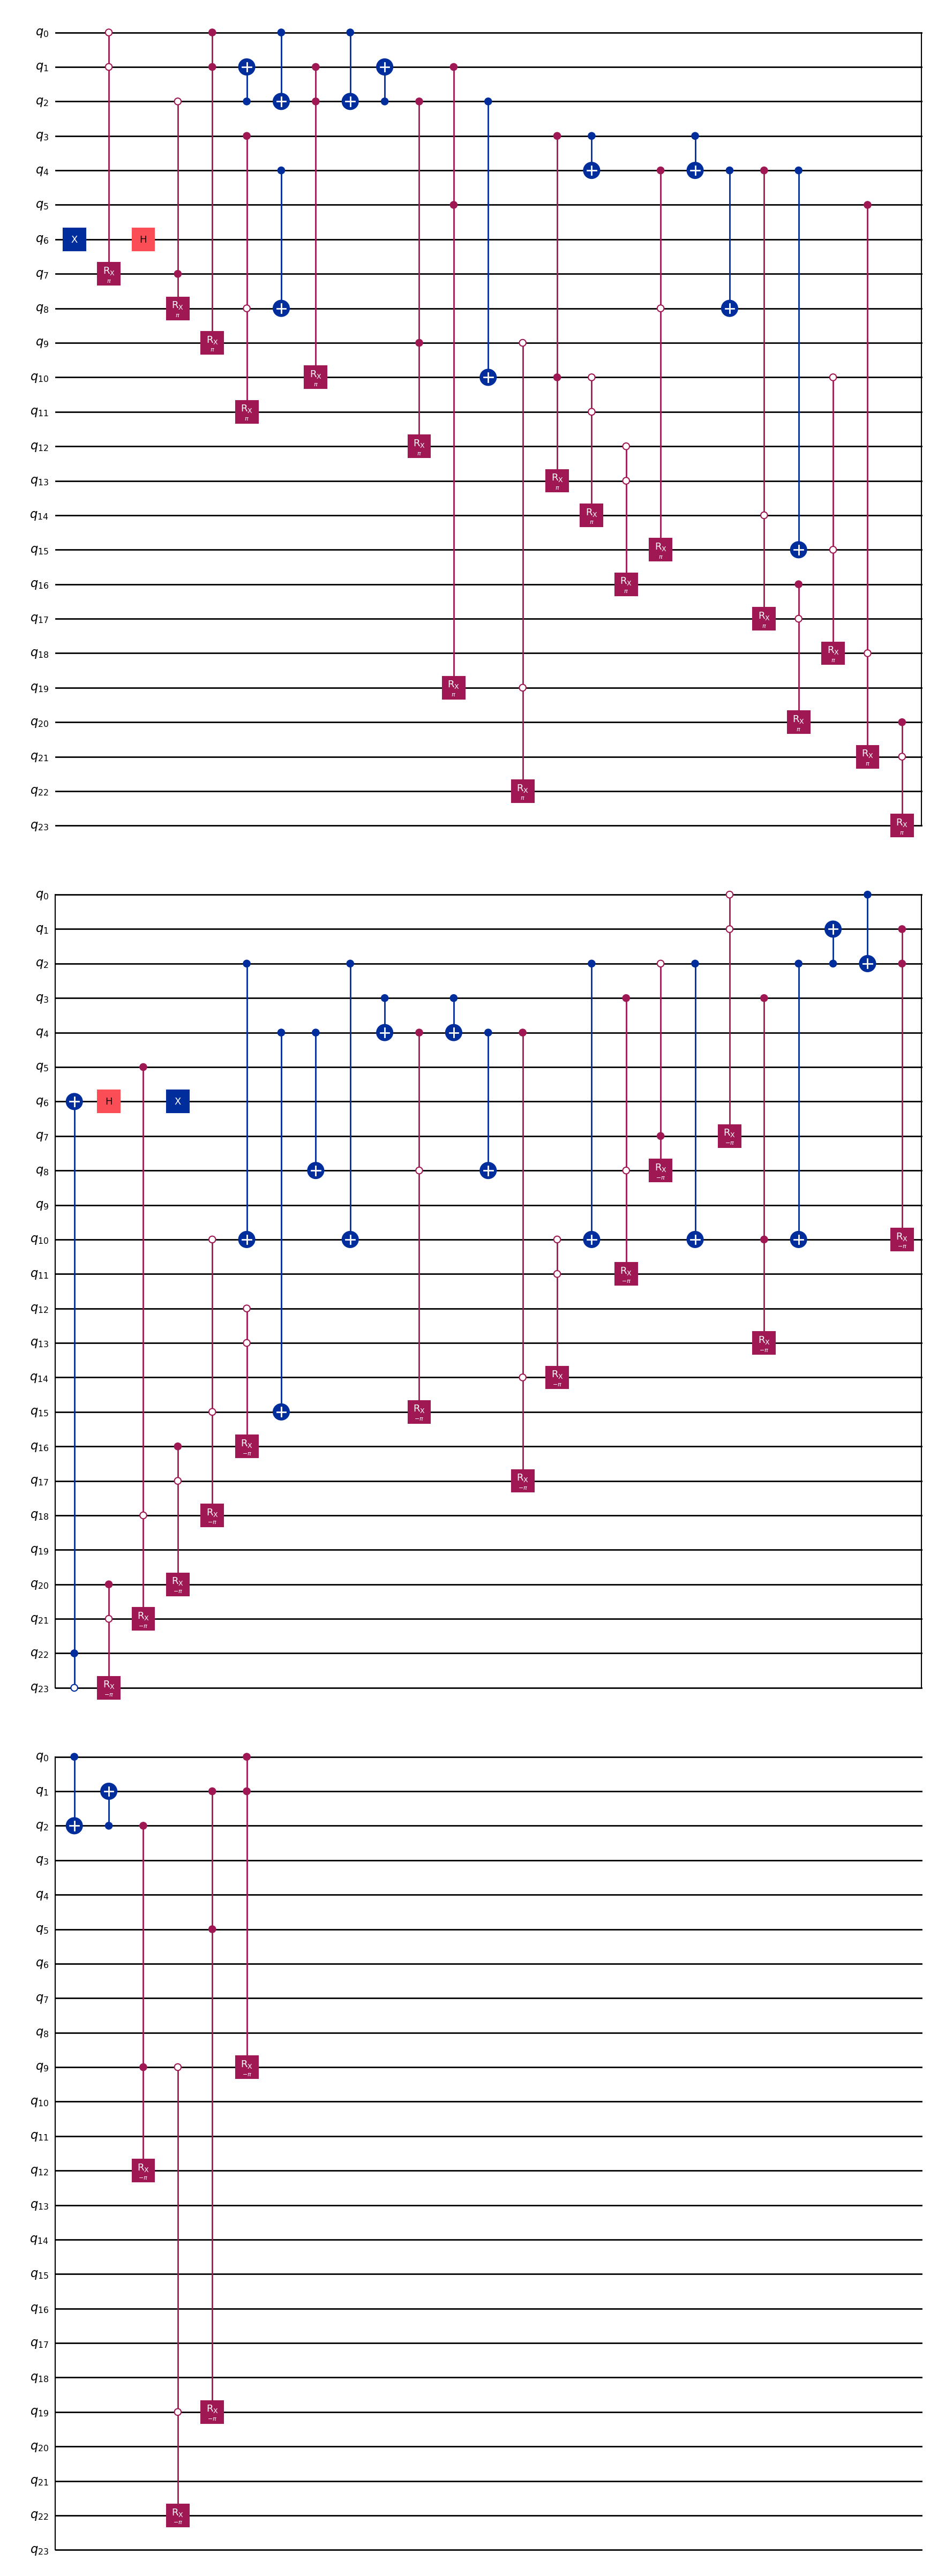

In [ ]:
from benchmarklib.pipeline import PipelineCompiler, PipelineStep
from benchmarklib.pipeline.synthesis import XAGSynthesizer, Synthesizer
from benchmarklib import setup_logging

class PrintTransformedSource(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        if synthesizer.compilation_artifacts:
            print(synthesizer.compilation_artifacts['source'])

        return circuit

class CreateNXGraph(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        import pygraphviz

        if isinstance(synthesizer, XAGSynthesizer):
            dot_str = synthesizer.compilation_artifacts['xag_graphviz']
            A = pygraphviz.AGraph()
            A.from_string(dot_str)
            G = nx.drawing.nx_agraph.from_agraph(A)

            for node, data in G.nodes.data():
                try:
                    node_label = int(data['label'])
                    if node_label != 0:
                        data['label'] = f"input{node_label}"
                        data['color'] = 'green'
                    else:
                        data['color'] = 'cyan'
                except:
                    clr_map = {"XOR": "blue", "AND": "red"}
                    if node != "po0":
                        data['color'] = clr_map[data['label']]
                    pass

                del data['fillcolor']
                del data['shape']
                del data['style']
                #print((node, data))
                

            for u, v, data in G.edges.data():
                data['negated'] = data['style'] == "dashed"
                del data['style']
                #print(data)
            
            color_map = []
            for node in G.nodes:
                color_map.append(G.nodes[node].get('color', 'gray')) # Use 'gray' as default

            synthesizer.compilation_artifacts['color_map'] = color_map
            display(nx.draw(G, node_color=color_map, with_labels=True))
            synthesizer.compilation_artifacts['xag'] = G
        else:
            print("WARNING: Not XAG Synthesizer, cannot perform graph operations")

        return circuit
    

class BoolFunctionFromNXGraph(PipelineStep):

    @property
    def name(self) -> str:
        return self.__class__.__name__

    def transform(self, synthesizer: Synthesizer, circuit: QuantumCircuit, **kwargs) -> QuantumCircuit:
        if isinstance(synthesizer, XAGSynthesizer):
           G = synthesizer.compilation_artifacts['xag']

           if not isinstance(G, nx.MultiDiGraph):
               raise ValueError("Expected nx XAG")
           
           G_rev = G.to_directed().reverse()
           color_map = synthesizer.compilation_artifacts['color_map']
           #display(nx.draw(G_rev, node_color=color_map, with_labels=True))
           
           nodes = list(nx.topological_sort(G_rev))
           for node in nodes:
               print(G_rev[node])

           print("\nSTARTING EXPRESSION BUILDER")
           expr = self.build_expression(G_rev, nodes[2])

           # check final edge to see if we need to negate our expr
           # first edge is always the one we want, nx was giving me issues so we put it in a loop
           for u, v, data in G.in_edges("po0", data=True):
               if data['negated']:
                   expr = sympy.Not(expr)
                   print(expr)
               synthesizer.compilation_artifacts['reduced_expr'] = expr
               return circuit
        else:
            print("WARNING: Not XAG Synthesizer, cannot perform graph operations")
            return circuit

    def build_expression(self, graph: nx.MultiDiGraph, node, memo=None):
        
        """
        Recursively builds a sympy boolean expression from a graph,
        starting from the output node.

        Args:
            graph (nx.MultiDiGraph): The graph to traverse.
            node_id: The ID of the current node to process.
            memo (dict): A dictionary to store results and avoid recomputing.

        Returns:
            A sympy boolean expression for the subtree
            rooted at the given node.
        """
        if memo is None:
            memo = {}
        
        # Check if we have already computed this node's expression
        if node in memo:
            return memo[node]

        #print(graph[node], graph.nodes[node])
        node_label = graph.nodes[node]['label']

        # Handle input nodes which don't have an operation
        if "input" in node_label:
            # There should only be incoming edges to the reversed graph input nodes.
            for u, v, key, data in graph.in_edges(node, keys=True, data=True):
                is_negated = data.get('negated', False)
                input_expr = sympy.Symbol(f"x{node_label[5:]}") # name variable in sympy xNUM 
                
                if is_negated:
                    result = sympy.Not(input_expr)
                else:
                    result = input_expr
                memo[node] = result
                return result

        # Recursive step: The node is a logic gate.
        gate_type = node_label.upper()
        sub_expressions = []

        # Iterate through the incoming edges to get the parent nodes and edge data.
        for u, v, key, data in graph.out_edges(node, keys=True, data=True):
            is_negated = data.get('negated', False)
            
            # Recursively build the expression for the parent node.
            parent_expression = self.build_expression(graph, v, memo)
            
            # Apply negation if the edge is dashed.
            if is_negated:
                sub_expressions.append(sympy.Not(parent_expression))
            else:
                sub_expressions.append(parent_expression)
        
        # Join the sub-expressions with the appropriate operator.
        if gate_type == 'XOR':
            result = sympy.Xor(*sub_expressions)
        elif gate_type == 'AND':
            result = sympy.And(*sub_expressions)
        else:
            # Fallback for other gate types
            result = f"({gate_type} {str(sub_expressions)})" 
            
        # Store the result in the memoization dictionary before returning.
        memo[node] = result
    
        return result


compiler = PipelineCompiler(synthesizer=XAGSynthesizer(), 
                            steps = [
                                PrintTransformedSource(),
                                ])

result = compiler.compile(clique_problem, clique_size=3)

display(result.synthesis_circuit.draw('mpl'))

{'source': 'def clique_oracle(vertices: BitVec(6, \'000000\')) -> BitVec(1):\n    """Counts cliques of size 2 in a graph specified by the edge list."""\n    s = BitVec(1, 1)\n    s = s & ~(vertices[0] & vertices[1])\n    s = s & ~(vertices[1] & vertices[5])\n    s_0_0 = BitVec(1, 1)\n    s_0_1 = BitVec(1, 0)\n    s_0_2 = BitVec(1, 0)\n    s_0_3 = BitVec(1, 0)\n    s_1_0 = BitVec(1, 1)\n    s_1_1 = s_0_1 | vertices[0] & s_0_0\n    s_1_2 = BitVec(1, 0)\n    s_1_3 = BitVec(1, 0)\n    s_2_0 = BitVec(1, 1)\n    s_2_1 = s_1_1 | vertices[1] & s_1_0\n    s_2_2 = s_1_2 | vertices[1] & s_1_1\n    s_2_3 = BitVec(1, 0)\n    s_3_0 = BitVec(1, 1)\n    s_3_1 = s_2_1 | vertices[2] & s_2_0\n    s_3_2 = s_2_2 | vertices[2] & s_2_1\n    s_3_3 = s_2_3 | vertices[2] & s_2_2\n    s_4_0 = BitVec(1, 1)\n    s_4_1 = s_3_1 | vertices[3] & s_3_0\n    s_4_2 = s_3_2 | vertices[3] & s_3_1\n    s_4_3 = s_3_3 | vertices[3] & s_3_2\n    s_5_0 = BitVec(1, 1)\n    s_5_1 = s_4_1 | vertices[4] & s_4_0\n    s_5_2 = s_4_2 |

None

{'max_width_level': 0, 'max_width': 6, 'longest_path_len': 10, 'and_dist_by_level': [0, 3, 4, 1, 3, 2, 2, 1, 1, 1], 'xor_dist_by_level': [0, 3, 0, 2, 0, 1, 0, 0, 0, 0], 'and_count': 18, 'xor_count': 6, 'num_nodes': 32}


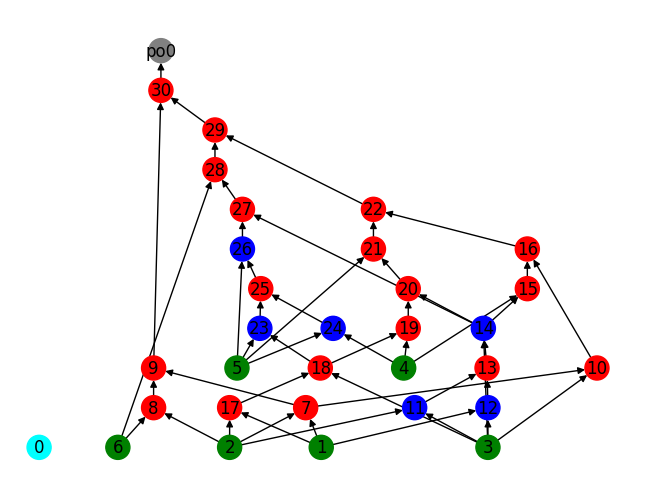

In [8]:
from nxag import PyXAG

print(result.artifacts)
nx_xag = result.artifacts['nxag']

py_xag = PyXAG().from_nx(G=nx_xag)

display(py_xag.draw())



print(py_xag.compute_graph_stats())

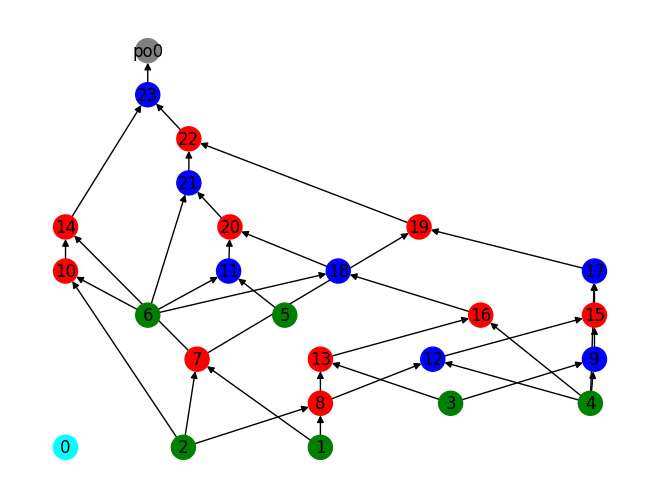

In [ ]:
ln = py_xag.to_tweedledum_logicnetwork()

py_xag2 = PyXAG().from_tweedledum_xag(ln)
py_xag2_pos = nx.drawing.nx_agraph.graphviz_layout(py_xag2.G, prog='dot')

nx.draw(py_xag2.G, py_xag2_pos, node_color=py_xag2.color_map, with_labels=True)

# ANF Cut 

## Exploring Cuts

{'max_width_level': 0, 'max_width': 6, 'longest_path_len': 9, 'and_dist_by_level': [0, 3, 2, 2, 0, 2, 0, 1, 0], 'xor_dist_by_level': [0, 2, 1, 0, 2, 0, 1, 0, 1], 'and_count': 10, 'xor_count': 7, 'num_nodes': 25}

ANF Cut for Level 9 : ['19', '20']

ANF Cut for Level 8 : ['19', '20']
New inputs ['23']
x1
Expr x1


ANF Cut for Level 7 : ['19', '20']
New inputs ['14', '22']
x1 ^ x2
x1 ^ x2

Cost -0.2


ANF Cut for Level 6 : ['19', '20']
New inputs ['19', '14', '21']
x2 ^ (x1 & x3)
x2 ^ (x1 & x3)

Cost -0.1


ANF Cut for Level 5 : ['19', '20']
New inputs ['20', '19', '6', '14']
x4 ^ (x2 & ~(x1 ^ x3))
x2 ^ x4 ^ (x1 & x2) ^ (x2 & x3)

Cost -0.2


ANF Cut for Level 4 : ['19', '20']
New inputs ['6', '7', '16', '17']
x2 ^ (x2 & x4 & ~(x1 ^ (x1 & ~(x1 ^ x3))))
x2 ^ (x2 & x4) ^ (x1 & x2 & x4) ^ (x1 & x2 & x3 & x4)

Cost 22.9


ANF Cut for Level 3 : ['19', '20']
New inputs ['4', '5', '6', '7', '15']
(x4 & ~x3) ^ (x4 & ~(x1 ^ x5) & ~(x3 ^ ((x2 ^ x3) & ~(x3 ^ ~x1))))
(x1 & x4) ^ (x3 & x4) ^ (x4 & x5

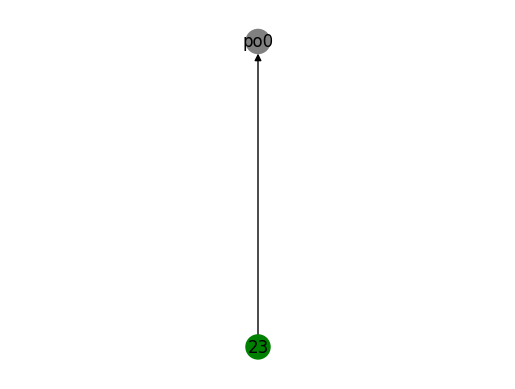

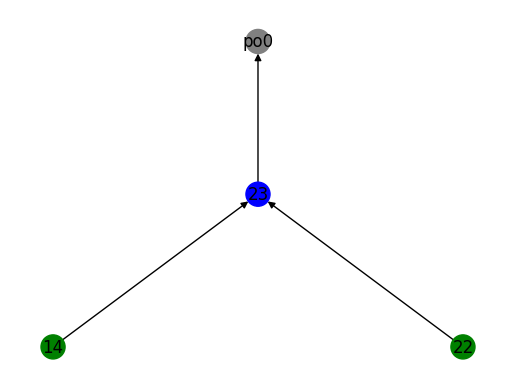

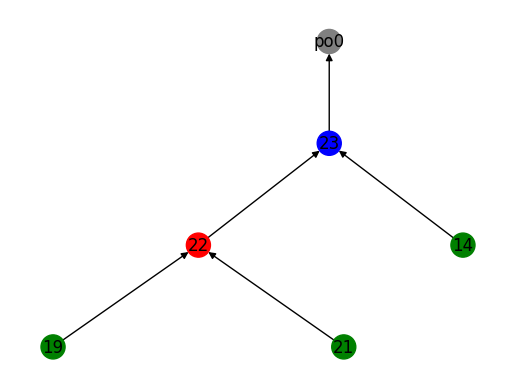

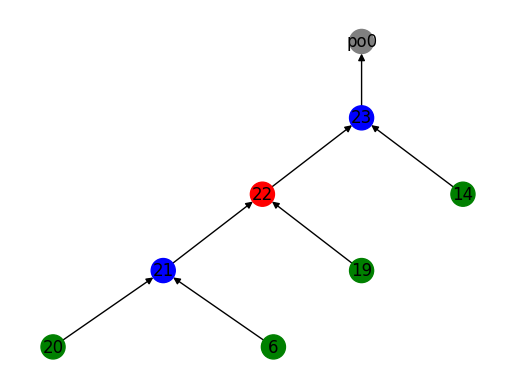

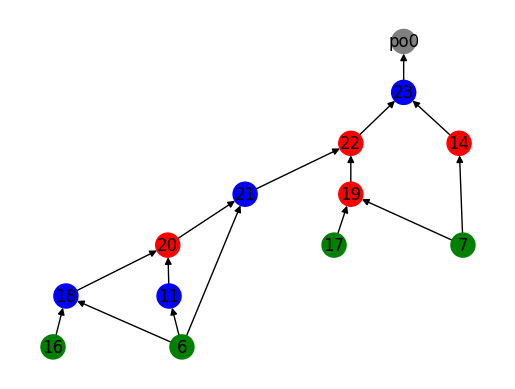

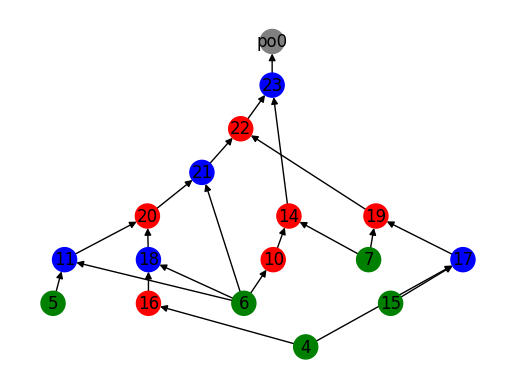

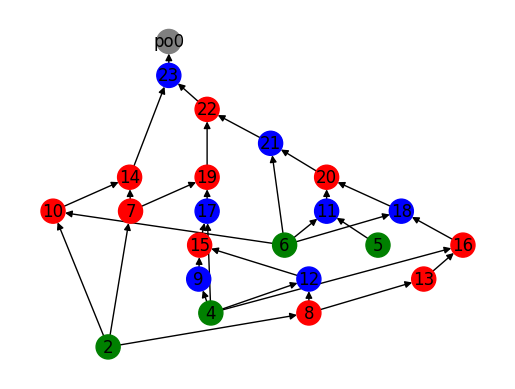

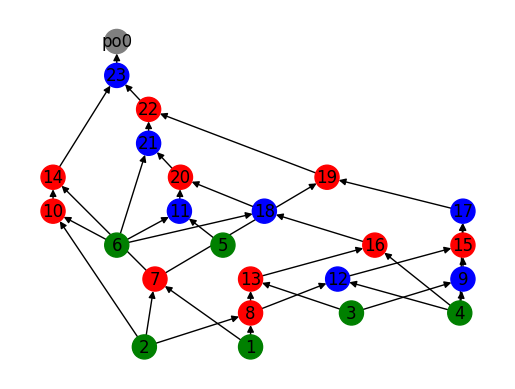

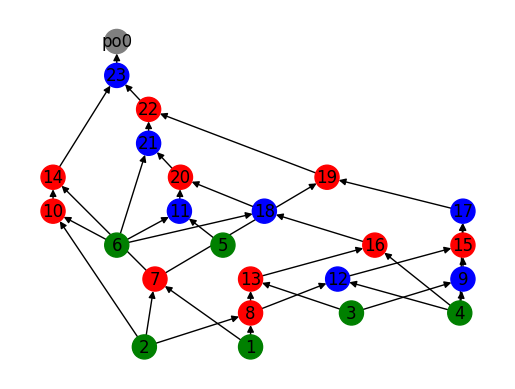

In [ ]:
# exploring cuts
import matplotlib.pyplot as plt

from copy import deepcopy

print(py_xag2.compute_graph_stats())


def cost(expression):

    def T_cost(degree: int):
        match degree:
            case 0: 
                return -0.1
            case 2: 
                return 0
            case 3: 
                return 7
            case 4: 
                return 16
            case _:  
                return 2**degree

    print(expression)
    anf = expression.to_anf()
    print(anf)

    cost = 0

    for clause in anf.args:
        cost += T_cost(len(clause.args))
    print()

    return cost

verts_in_cut = set()

# this loop gave us level 5 as best cut
for lvl, nodes in reversed(sorted(py_xag2.nodes_at_level.items())):
    
    print("\n", "="*30)
    print("ANF Cut for Level", lvl, ":", py_xag2.nodes_at_level[5])

    verts_in_cut.update(nodes)

    if lvl == py_xag2.longest_path:
        continue # ignore 'po0' level

    # make subgraph of the cut, 
    pyxag_sub = PyXAG().from_nx(py_xag2.G.subgraph(verts_in_cut))

    # fill in input gaps
    nodes_to_add = []
    for node in pyxag_sub.G.nodes:
        # if a node has degree 1 then it is missing an input (if its not po0)
        if node != 'po0' and pyxag_sub.G.in_degree(node) == 1:
            # check original graph for edges into this node
            for e in py_xag2.G.in_edges(node):
                # add any inputs to this node to the subgraph
                if e[0] not in pyxag_sub.G.nodes:
                    nodes_to_add.append(e[0])

    verts_in_cut.update(nodes_to_add)
    subg = deepcopy(py_xag2.G.subgraph(verts_in_cut))

    # collect new input nodes
    new_inputs = []
    for node in subg.nodes:
        if subg.in_degree(node) == 0:
            new_inputs.append(node)

    print("New inputs", new_inputs)

    for i, node in enumerate(new_inputs):
        subg.nodes[node]['label'] = f"input{i + 1}"
        subg.nodes[node]['color'] = "green"

    pyxag_sub = PyXAG().from_nx(subg)
    fig, ax = plt.subplots()
    pos = nx.drawing.nx_agraph.graphviz_layout(pyxag_sub.G, prog='dot')
    nx.draw(pyxag_sub.G, pos, node_color=pyxag_sub.color_map, with_labels=True, ax=ax)
    expr = pyxag_sub.sympy_expr()

    try:
        print("Cost", cost(expr))
    except:
        print("Expr", expr)
    
    print()

## Making Cut and sub-expressions

{'max_width_level': 0, 'max_width': 6, 'longest_path_len': 9, 'and_dist_by_level': [0, 3, 2, 2, 0, 2, 0, 1, 0], 'xor_dist_by_level': [0, 2, 1, 0, 2, 0, 1, 0, 1], 'and_count': 10, 'xor_count': 7, 'num_nodes': 25}
ANF Cut for Level 5 : ['19', '20']
New inputs ['20', '19', '6', '14']
20 {'label': 'AND', 'color': 'red'}
19 {'label': 'AND', 'color': 'red'}
6 {'label': 'input6', 'color': 'green'}
14 {'label': 'AND', 'color': 'red'}


None

x4 ^ (x2 & ~(x1 ^ x3))
x2 ^ x4 ^ (x1 & x2) ^ (x2 & x3)

Cost -0.2
Computing ancestors of  20
Subgraph Expr (x5 ^ x6) & ~(x6 ^ (x1 & x2 & x3 & x4))
Computing ancestors of  19
Subgraph Expr ~(~x1 & ~x2) & ~(x4 ^ ((x3 ^ x4) & ~(x4 ^ (x1 & x2))))
Computing ancestors of  6
Subgraph Expr x6
Computing ancestors of  14
Subgraph Expr ~(x1 & x2) & ~(x2 & x6)


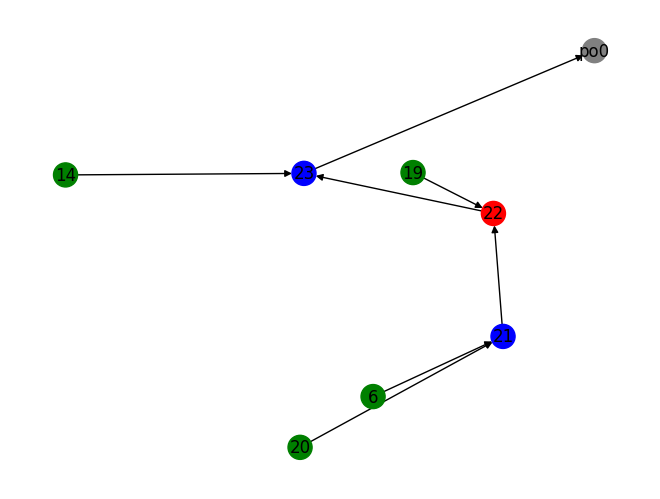

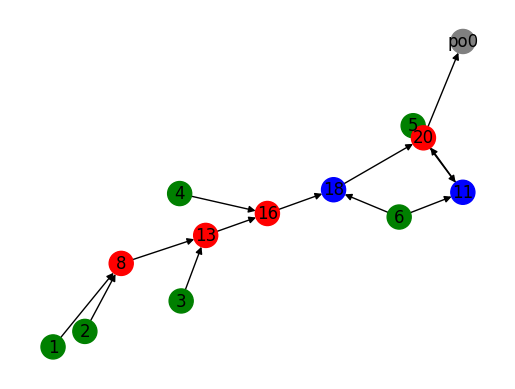

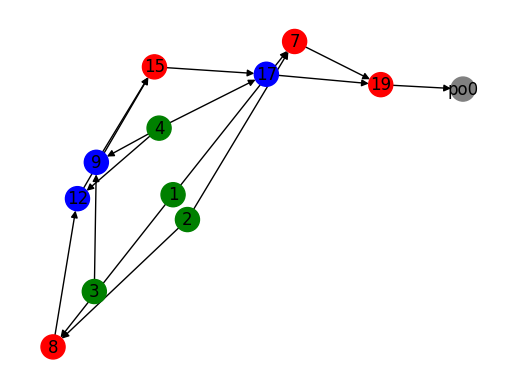

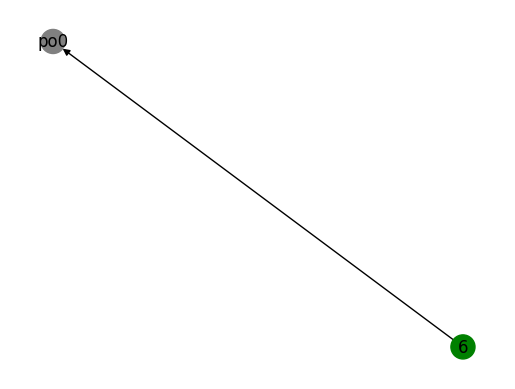

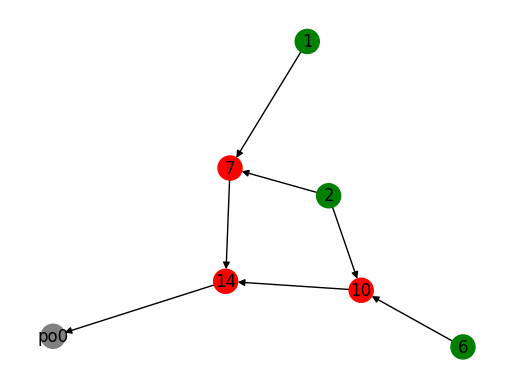

In [ ]:
import matplotlib.pyplot as plt

from copy import deepcopy

print(py_xag2.compute_graph_stats())


def cost(expression):

    def T_cost(degree: int):
        match degree:
            case 0: 
                return -0.1
            case 2: 
                return 0
            case 3: 
                return 7
            case 4: 
                return 16
            case _:  
                return 2**degree

    print(expression)
    anf = expression.to_anf()
    print(anf)

    cost = 0

    for clause in anf.args:
        cost += T_cost(len(clause.args))
    print()

    return cost

verts_in_cut = set()

# this loop gave us level 5 as best cut
#for lvl, nodes in reversed(sorted(py_xag2.nodes_at_level.items())):

lvl = 5
for level in range(5, py_xag2.longest_path+1):
    verts_in_cut.update(py_xag2.nodes_at_level[level])

    
print("ANF Cut for Level", lvl, ":", py_xag2.nodes_at_level[5])


# if lvl == py_xag2.longest_path:
#     continue # ignore 'po0' level

# make subgraph of the cut, 
pyxag_sub = PyXAG().from_nx(py_xag2.G.subgraph(verts_in_cut))

# fill in input gaps
nodes_to_add = []
for node in pyxag_sub.G.nodes:
    # if a node has degree 1 then it is missing an input (if its not po0)
    if node != 'po0' and pyxag_sub.G.in_degree(node) == 1:
        # check original graph for edges into this node
        for e in py_xag2.G.in_edges(node):
            # add any inputs to this node to the subgraph
            if e[0] not in pyxag_sub.G.nodes:
                nodes_to_add.append(e[0])

verts_in_cut.update(nodes_to_add)
subg = deepcopy(py_xag2.G.subgraph(verts_in_cut))

# collect new input nodes
new_inputs = []
for node in subg.nodes:
    if subg.in_degree(node) == 0:
        new_inputs.append(node)

print("New inputs", new_inputs)
for node in new_inputs:
    print(node, py_xag2.G.nodes[node])

for i, node in enumerate(new_inputs):
    subg.nodes[node]['label'] = f"input{i + 1}"
    subg.nodes[node]['color'] = "green"

pyxag_sub = PyXAG().from_nx(subg)
display(nx.draw(pyxag_sub.G, node_color=pyxag_sub.color_map, with_labels=True))
expr = pyxag_sub.sympy_expr()

try:
    print("Cost", cost(expr))
except:
    print("Expr", expr)


for node in new_inputs:
    fig, ax = plt.subplots()

    print("Computing ancestors of ", node)
    ancestor_set = nx.ancestors(py_xag2.G, node)
    ancestor_set.add(node)
    ancestor_g = py_xag2.G.subgraph(ancestor_set).copy()

    node_to_connect = None
    for node in ancestor_g.nodes:
        if node != "0" and ancestor_g.out_degree(node) == 0:
            node_to_connect = node
            break

    if node not in ancestor_g.nodes:
        node_info = py_xag2.G.nodes[node]
        ancestor_g.add_node(node, label=node_info['label'], color=node_info['color'])
    
    ancestor_g.add_node("po0", color="gray")
    ancestor_g.add_edge(node, "po0", negated=False)
 
    pyxag_ancestor = PyXAG().from_nx(ancestor_g)

    pyxag_ancestor.optimize_xag()
    print("Subgraph Expr", pyxag_ancestor.sympy_expr())
    nx.draw(pyxag_ancestor.G, node_color=pyxag_ancestor.color_map, with_labels=True, ax=ax )

# Code to propogate input 

Propogating Input  1
x1 & ((~x2 & ~(x2 & x6)) ^ (~x2 & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & (x4 ^ ~x3)))))
0 [('0', '7', {'negated': True}), ('0', '8', {'negated': False})]
1 [('1', '25', {'negated': False})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': Fal

None

x1 & ((~x2 & ~(x2 & x6)) ^ (~x2 & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & (x4 ^ ~x3)))))
0 [('0', '7', {'negated': False}), ('0', '8', {'negated': True})]
1 [('1', '25', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False})]
14 [('14', '23',

None

Propogating Input  2
x2 & ~(~(x4 ^ (~(x1 ^ x4) & (x4 ^ ~x3))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x4)))))
0 [('0', '7', {'negated': True}), ('0', '8', {'negated': False}), ('0', '10', {'negated': True})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '25', {'negated': False})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False

None

x2 & ~(~(x4 ^ (~(x1 ^ x4) & (x4 ^ ~x3))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x4)))))
0 [('0', '7', {'negated': False}), ('0', '8', {'negated': True}), ('0', '10', {'negated': False})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '25', {'negated': True})]
3 [('3', '9', {'negated': False}), ('3', '13', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': False})]
14 [('14', '23', 

None

Propogating Input  3
x3 & ((~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & ~(x4 ^ (x1 & ~x2))))))
0 [('0', '9', {'negated': True}), ('0', '13', {'negated': False})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '25', {'negated': False})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13

None

x3 & ((~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x6 ^ (~x6 & (x5 ^ x6))) & ~(x4 ^ (~x4 & ~(x4 ^ (x1 & ~x2))))))
0 [('0', '9', {'negated': False}), ('0', '13', {'negated': True})]
1 [('1', '7', {'negated': False}), ('1', '8', {'negated': True})]
2 [('2', '7', {'negated': False}), ('2', '8', {'negated': True}), ('2', '10', {'negated': False})]
3 [('3', '25', {'negated': True})]
4 [('4', '9', {'negated': False}), ('4', '12', {'negated': False}), ('4', '16', {'negated': True}), ('4', '17', {'negated': False})]
5 [('5', '11', {'negated': False})]
6 [('6', '10', {'negated': False}), ('6', '11', {'negated': False}), ('6', '18', {'negated': False}), ('6', '21', {'negated': False})]
7 [('7', '14', {'negated': True}), ('7', '19', {'negated': True})]
8 [('8', '12', {'negated': False}), ('8', '13', {'negated': False})]
9 [('9', '15', {'negated': False})]
10 [('10', '14', {'negated': True})]
11 [('11', '20', {'negated': False})]
12 [('12', '15', {'negated': True})]
13 [('13', '16', {'negated': F

None

None

(~(x2 & x6) & ~(x2 & ~x1)) ^ (~(x2 & ~x1) & ~(x4 ^ ((x4 ^ ~x3) & ~(x4 ^ (x1 & ~x2)))) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (x1 & x3 & ~x2 & ~x4)))))


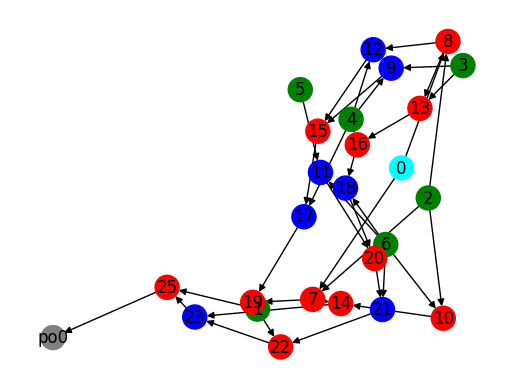

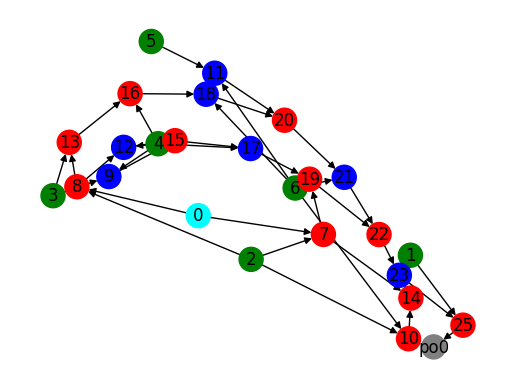

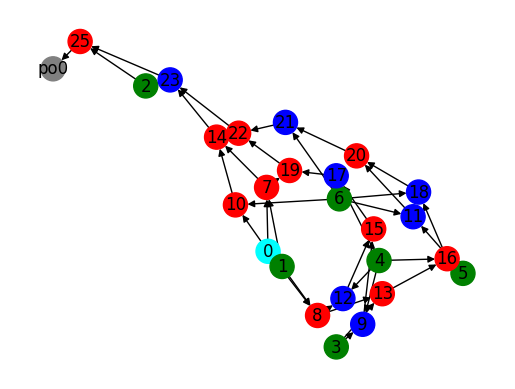

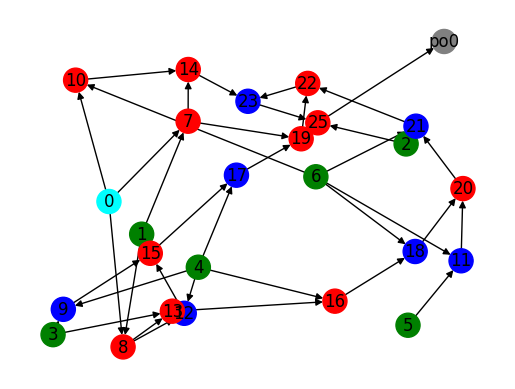

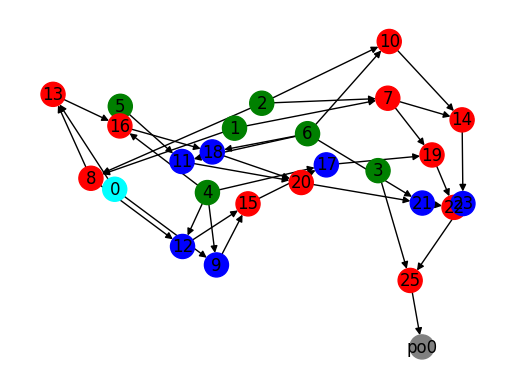

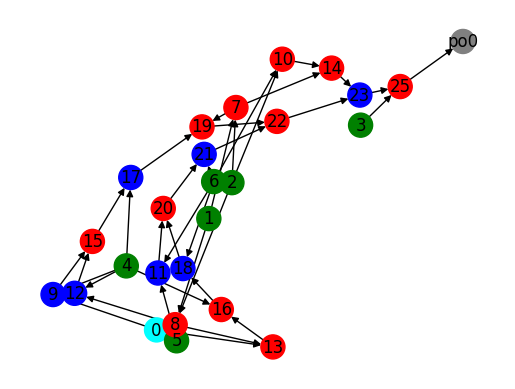

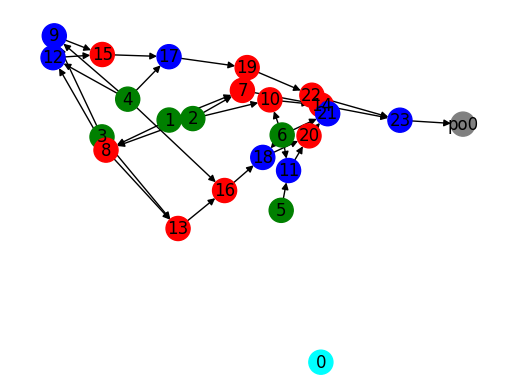

In [ ]:
import matplotlib.pyplot as plt
from nxag import _assign_color_map

def unit_prop(pyxag: PyXAG, input: str):
    from copy import deepcopy
    # given an input node, create two graphs one assuming input is TRUE and the other assuming input is False

    # f(x, y, ...) -> x * f(1, y, ...) (assuming x is true)
    pyxag_assume_true = PyXAG().from_nx(deepcopy(pyxag.G))
    # f(x, y, ...) -> ~x * f(0, y, ...) (assuming x is false)
    pyxag_assume_false = PyXAG().from_nx(deepcopy(pyxag.G))

    pyxag_assume_true = prop_signal(pyxag_assume_true, input, True)
    pyxag_assume_false = prop_signal(pyxag_assume_false, input, False)

    pyxag_assume_true.optimize_xag()
    pyxag_assume_false.optimize_xag()

    return pyxag_assume_true, pyxag_assume_false



def prop_signal(pyxag: PyXAG, input: str, assumption: bool):
    # replace all edges leaving input with the constant signal and add literal ANDed with previous output
    new_edges = []
    old_edges = []
   
    for (u, v, data) in pyxag.G.out_edges(input, data=True):
        # create new edges from 0 node to v
        # input assumption | edge is negated | 0 should be negated 
        #     True              True                False
        #     True              False               True    
        #     False             True                True   
        #     False             False               False
        new_edges.append(("0", v, {'negated': assumption ^ data['negated']}))
        old_edges.append((u, v))
        
    # remove old out_edges & insert new ones
    pyxag.G.remove_edges_from(old_edges)
    pyxag.G.add_edges_from(new_edges)

    # stitch together the assumtion with the new function
    old_output_edges = []
    new_output_edges = []

    final_and = str(pyxag.G.number_of_nodes())
    pyxag.G.add_node(final_and, label="AND", color="red")
    for (u, v, data) in pyxag.G.in_edges("po0", data=True):
        old_output_edges.append((u, v))

        # add edge from u to new AND node with input 
        new_output_edges.append((u, final_and, {'negated': data['negated']}))
        new_output_edges.append((input, final_and, {'negated': not assumption}))
        break

    pyxag.G.remove_edges_from(old_output_edges)
    pyxag.G.add_edges_from(new_output_edges)
    
    pyxag.G.add_edge(final_and, "po0", negated=False)
    pyxag.color_map = _assign_color_map(pyxag.G)
    return pyxag

for input in ["1", "2", "3"]:
    assume_true, assume_false = unit_prop(py_xag2, input)
    print("Propogating Input ", input)
    for pyxag in [assume_true, assume_false]:


        print(pyxag.sympy_expr())
        for node in pyxag.G.nodes:
            print(node, list(pyxag.G.out_edges(node, data=True)))

        fig, ax = plt.subplots()
        display(nx.draw(pyxag.G, ax=ax, node_color=pyxag.color_map, with_labels=True))

fig, ax = plt.subplots()
display(nx.draw(py_xag2.G, node_color=py_xag2.color_map, with_labels=True))
print(py_xag2.sympy_expr())

In [ ]:

# optimize new graph

py_xag_assume_3_is_true = PyXAG().from_nx(G_assume_true)
py_xag_assume_3_is_true.optimize_xag()
display(nx.draw(py_xag_assume_3_is_true.G, node_color=py_xag_assume_3_is_true.color_map, with_labels=True))


NameError: name 'G_assume_true' is not defined

# Graph Operations


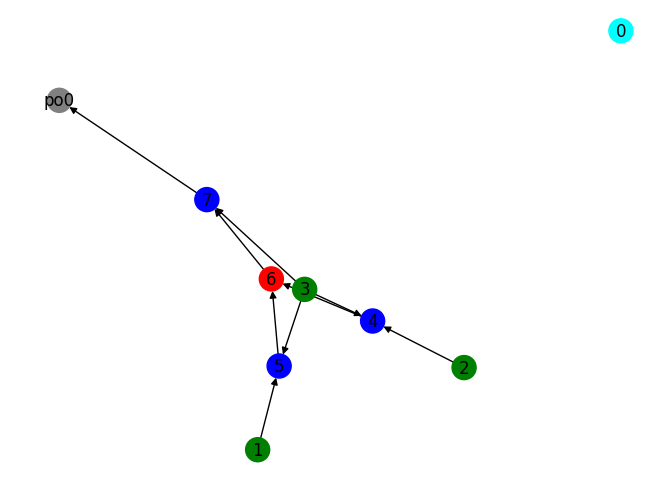

In [ ]:
xag = result.artifacts['xag']
color_map = result.artifacts['color_map']
nx.draw(xag, node_color=color_map, with_labels=True)

In [ ]:
def decompose(xag: nx.MultiDiGraph, input_nodes, level: int = 1):
    from copy import deepcopy
    from collections import deque

    """
    Recursively decompose graph and dynamically choose optimal subgraphs
    """

    # Base Case: level 3
    if level >= 3:
        return xag

    # strategy: Loop over each input variable and do Shannon expansion to create 2 graphs (DPLL)
    for input in input_nodes: 
        g1 = deepcopy(xag) # assume input is true

        queue = deque()
        queue.append((input, sympy.true))

        # explore children of input node
        for _, v, data in g1.out_edges(input, data=True):
            # check edge for negation and queue the propogating signal 
            outgoing_signal = sympy.false if data['negated'] else sympy.true
            
            # queue nodes with a new incoming constant signal
            queue.append((v, outgoing_signal))

        g1.remove_node(input)

        while not queue:
            node, insignal = queue.popleft()
            node_label = g1.nodes[node].get('label', 'po0')

            in_edge

            # given changed incoming signal, check for outgoing changes
            if node_label == "XOR":




decompose(xag, ["1"])


IndentationError: expected an indented block after 'if' statement on line 37 (1826051898.py, line 42)

# Benchmarking Expressions for Cliques

In [ ]:
import sympy.logic.boolalg as boolalg

for sym in expr.free_symbols:
    print(expr.count(sym))

7
2
9
5


In [ ]:
from collections import defaultdict

big_expr_str = "~(x5 & x6) & ~(x5 & x7) & ~(x1 ^ (x1 & ~x3 & ~x6 & ~x8)) & ~(~(x6 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))))) & ~((x1 & x2 & x3) ^ ((x5 ^ (x1 & x2 & x3)) & ~(x4 ^ (~(x4 ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))) & ~(x4 ^ (x1 & x2 & x3) ^ (x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3))))))))) & ~(x7 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))))) & ~(x8 & ~(~(x1 & x2 & x3) & ~(x4 & (x3 ^ ((x1 ^ x3) & (x2 ^ x3)))) & ~(x5 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)))) & ~(x6 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x5 & ~(~x1 & ~x2 & ~x3 & ~x4)))) & ~(x7 & ~(~(x3 ^ ((x1 ^ x3) & (x2 ^ x3))) & ~(x4 & ~(~x1 & ~x2 & ~x3)) & ~(x6 ^ ((x5 ^ x6) & ~(x6 ^ (~x1 & ~x2 & ~x3 & ~x4)))))))))" 


sympy_big_expr = sympy.parse_expr(big_expr_str)

#4 defaultdict(<class 'int'>, {1: 4}) {'x7': 3, 'x2': 26, 'x5': 9, 'x1': 28, 'x3': 49, 'x6': 8, 'x8': 2, 'x4': 17}

true_counts = 0
for t, v in boolalg.truth_table(sympy_big_expr, symbols("x1 x3 x4")):
    counts = defaultdict(int)
    for sym in v.free_symbols:
        counts[sym] += v.count(sym)
    print(v.args)
    print(counts)
    


print(f"{true_counts}/{2**8} ({true_counts / 2 **8:.02f}%)inputs")


(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6 & x7) & ~(x8 & ~(~(x2 & x5 & x6) & ~(x7 & (x6 ^ ((x5 ^ x6) & ~(x6 ^ ~x2))))))))
defaultdict(<class 'int'>, {x5: 5, x7: 3, x2: 3, x8: 1, x6: 6})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~(x6 ^ (~x6 & (x5 ^ x6)))))))))
defaultdict(<class 'int'>, {x5: 8, x7: 3, x2: 6, x8: 1, x6: 7})
(~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)) & ~(x7 & ~(~x2 & ~x5 & ~x6)) & ~(x8 & ~(~x2 & ~x5 & ~x6 & ~x7))))
defaultdict(<class 'int'>, {x5: 6, x7: 3, x2: 4, x8: 1, x6: 4})
(~x6, ~x8, ~(x5 & x6), ~(x5 & x7), ~(~(x2 & x5 & x6) & ~(x7 & ~(~(x2 & x5) & ~(x6 & ~(~x2 & ~x5)))) & ~(x8 & ~(~(x2 & x5) & ~(x

In [ ]:
exp1 = sympy.parse_expr("a ^ (a & b)")
exp2 = sympy.parse_expr("a & ~b")

syms = symbols("a b c")
equal = True
for (t1, v1), (t2, v2) in zip(boolalg.truth_table(exp1, syms), boolalg.truth_table(exp2, syms)):
    print (v1, v2)

    if v1 != v2:
        equal = False

if equal == False:
    print("NOT Equivalent")
else: 
    print("Equivalent!")

False False
False False
False True
False True
True False
True False
False False
False False
NOT Equivalent


In [ ]:
sympy.Not(sympy.true)

False

In [ ]:
syms = sympy.symbols("x1 x2 x3")
expr = sympy.parse_expr("x1 & x2 & x3")
expr.to_anf()

x1 & x2 & x3

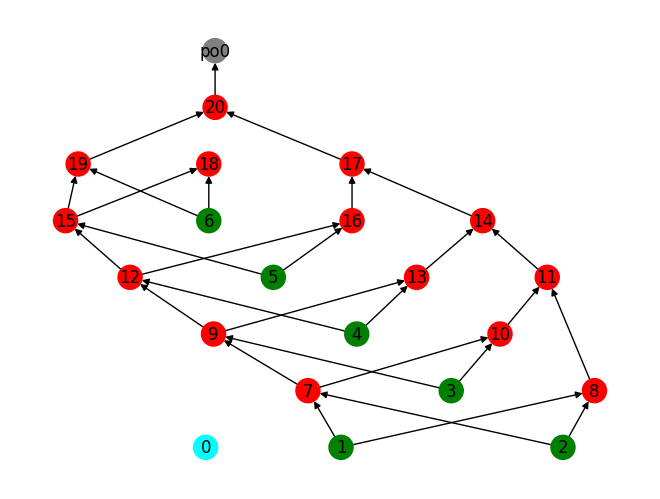

In [ ]:
from tweedledum.bool_function_compiler.decorators import circuit_input
from tweedledum.bool_function_compiler.quantum_circuit_function import QuantumCircuitFunction

from tweedledum import BitVec

@circuit_input(vertices= BitVec(6, "000000"))
def cardinality() -> BitVec(1):
    s_0_0 = BitVec(1, 1)
    s_0_1 = BitVec(1, 0)
    s_0_2 = BitVec(1, 0)
    s_1_0 = BitVec(1, 1)
    s_1_1 = s_0_1 | vertices[0] & s_0_0
    s_1_2 = BitVec(1, 0)
    s_2_0 = BitVec(1, 1)
    s_2_1 = s_1_1 | vertices[1] & s_1_0
    s_2_2 = s_1_2 | vertices[1] & s_1_1
    s_3_0 = BitVec(1, 1)
    s_3_1 = s_2_1 | vertices[2] & s_2_0
    s_3_2 = s_2_2 | vertices[2] & s_2_1
    s_4_0 = BitVec(1, 1)
    s_4_1 = s_3_1 | vertices[3] & s_3_0
    s_4_2 = s_3_2 | vertices[3] & s_3_1
    s_5_0 = BitVec(1, 1)
    s_5_1 = s_4_1 | vertices[4] & s_4_0
    s_5_2 = s_4_2 | vertices[4] & s_4_1
    s_6_0 = BitVec(1, 1)
    s_6_1 = s_5_1 | vertices[5] & s_5_0
    s_6_2 = s_5_2 | vertices[5] & s_5_1
    return s_6_2

qcf = QuantumCircuitFunction(cardinality)

pyxag_card = PyXAG().from_tweedledum_xag(qcf.logic_network())
pyxag.optimize_xag()

#nx.nx_agraph.write_dot(pyxag.G, 'test.dot')
pos = nx.drawing.nx_agraph.graphviz_layout(pyxag_card.G, prog='dot')
nx.draw(pyxag_card.G, pos, with_labels=True, node_color=pyxag_card.color_map)


In [ ]:
pyxag_card.sympy_expr()

~(~x1 & ~x2 & ~x3 & ~x4 & ~x5 & ~x6)

In [ ]:
for edge in pyxag_card.G.edges:
    print(edge, pyxag_card.G.edges[edge])

('1', '7', 0) {'negated': True}
('1', '8', 0) {'negated': False}
('2', '7', 0) {'negated': True}
('2', '8', 0) {'negated': False}
('3', '9', 0) {'negated': True}
('3', '10', 0) {'negated': False}
('4', '12', 0) {'negated': True}
('4', '13', 0) {'negated': False}
('5', '15', 0) {'negated': True}
('5', '16', 0) {'negated': False}
('6', '18', 0) {'negated': True}
('6', '19', 0) {'negated': False}
('7', '9', 0) {'negated': False}
('7', '10', 0) {'negated': True}
('8', '11', 0) {'negated': True}
('9', '12', 0) {'negated': False}
('9', '13', 0) {'negated': True}
('10', '11', 0) {'negated': True}
('11', '14', 0) {'negated': False}
('12', '15', 0) {'negated': False}
('12', '16', 0) {'negated': True}
('13', '14', 0) {'negated': True}
('14', '17', 0) {'negated': False}
('15', '18', 0) {'negated': False}
('15', '19', 0) {'negated': True}
('16', '17', 0) {'negated': True}
('17', '20', 0) {'negated': False}
('19', '20', 0) {'negated': True}
('20', 'po0', 0) {'negated': True}
